# Lesson 6: Essay Writer

In [1]:
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var]=getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage

使用SqliteSaver会出现'_GeneratorContextManager' object has no attribute 'get_next_version'错误。

In [3]:
"""
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")
"""

from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [4]:
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [53]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(
    model_name='qwen2',
    #model_name='deepseek-r1:32b',
    openai_api_base="http://127.0.0.1:11434/v1",
    openai_api_key="EMPTY",
    streaming=True
)

In [54]:
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections."""

In [55]:
WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 5-paragraph essays.\
Generate the best essay possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed: 

------

{content}"""

In [56]:
REFLECTION_PROMPT = """You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

In [57]:
RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can \
be used when writing the following essay. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max."""


In [58]:
RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max."""


In [59]:
from langchain_core.pydantic_v1 import BaseModel

class Queries(BaseModel):
    queries: List[str]

In [60]:
from tavily import TavilyClient
import os
tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

In [61]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT), 
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [62]:
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [63]:
def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    response = model.invoke(messages)
    return {
        "draft": response.content, 
        "revision_number": state.get("revision_number", 1) + 1
    }


In [64]:
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT), 
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [65]:
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [66]:
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

In [67]:
builder = StateGraph(AgentState)

In [68]:
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

In [69]:
builder.set_entry_point("planner")

In [70]:
builder.add_conditional_edges(
    "generate", 
    should_continue, 
    {END: END, "reflect": "reflect"}
)


In [71]:
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

In [72]:
graph = builder.compile(checkpointer=memory)

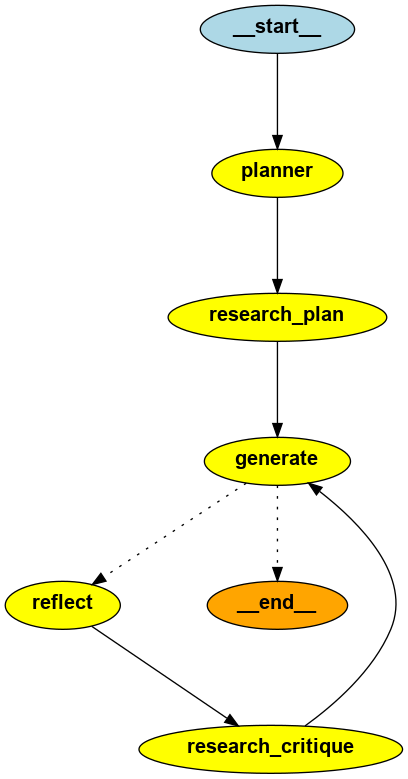

In [73]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

In [74]:
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    'task': "what is the difference between langchain and langsmith",
    "max_revisions": 2,
    "revision_number": 1,
}, thread):
    print(s)

{'planner': {'plan': "### Title: Understanding the Distinction between Langchain and Langsmith: Navigating Through Two Innovative Language Processing Platforms\n\n#### Introduction:\n1. **Context of AI-driven language processing tools**: Begin by introducing the significance of AI-powered natural language processing (NLP) in today's digital landscape.\n2. **Overview of Langchain and LangSmith**: Provide a brief overview of what Langchain and Langsmith are, highlighting their primary functions and applications.\n\n#### Body:\n\n**Part I: Defining Features**\n\n1. **Technical Overview of Langchain**\n   - **Core functionalities**: Explain the foundational capabilities of Langchain, such as its APIs for language understanding and generation.\n   - **Example uses**: Cite specific examples where Langchain has been successfully integrated, such as in conversational AI, document summarization, or code completion.\n\n2. **Feature Set of Langsmith**\n   - **Unique features**: Discuss the distin

/home/haoyu/anaconda3/envs/yolo/lib/python3.10/site-packages/langchain_openai/chat_models/base.py:1377: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(


ValidationError: 1 validation error for Queries
queries -> 0
  str type expected (type=type_error.str)

## Essay Writer Interface

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from helper import ewriter, writer_gui

In [ ]:
MultiAgent = ewriter()
app = writer_gui(MultiAgent.graph)
app.launch()